In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, log_loss,mean_squared_error,r2_score, mean_absolute_error, hamming_loss, f1_score,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from MLSMOTE import create_dataset, get_tail_label, get_index,get_minority_instace,nearest_neighbour,MLSMOTE

In [102]:
x_train=np.load("Training data/X_train.npy")
y_train=np.load("Training data/y_train.npy")
x_test=np.load("Testing data/X_test.npy")

In [103]:
x_train = pd.DataFrame(x_train).rename(columns={i: f"x_{i}" for i in range(111)})
y_train = pd.DataFrame(y_train).rename(columns={i: f"y_{i}" for i in range(111)})
x_test = pd.DataFrame(x_test).rename(columns={i: f"x_{i}" for i in range(111)})

In [104]:
print(x_train)

      x_0  x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8  x_9  ...  x_101  x_102  \
0    57.0  5.0  0.0  0.0  0.0  2.0  NaN  2.0  0.0  NaN  ...    3.0    0.0   
1    71.0  2.0  2.0  NaN  NaN  2.0  NaN  3.0  0.0  7.0  ...    5.0    NaN   
2    64.0  2.0  0.0  NaN  NaN  2.0  NaN  2.0  0.0  1.0  ...    4.0    0.0   
3    74.0  1.0  1.0  6.0  2.0  2.0  NaN  2.0  0.0  NaN  ...    4.0    0.0   
4    74.0  2.0  0.0  6.0  2.0  0.0  NaN  3.0  0.0  7.0  ...    6.0    0.0   
..    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
995  86.0  4.0  0.0  0.0  0.0  0.0  NaN  2.0  0.0  NaN  ...    2.0    0.0   
996  91.0  3.0  0.0  0.0  0.0  0.0  NaN  2.0  0.0  7.0  ...    5.0    0.0   
997  46.0  4.0  0.0  0.0  2.0  2.0  NaN  0.0  0.0  0.0  ...    5.0    0.0   
998  70.0  2.0  1.0  2.0  2.0  1.0  NaN  0.0  0.0  0.0  ...    4.0    0.0   
999  60.0  2.0  0.0  0.0  0.0  2.0  NaN  0.0  0.0  0.0  ...    5.0    0.0   

     x_103  x_104  x_105  x_106  x_107  x_108  x_109  x_110  
0      0.0   

In [105]:
missing_v_x_train = x_train.isnull().sum().sum()
missing_v_y_train = y_train.isnull().sum().sum()
missing_v_x_test = x_test.isnull().sum().sum()
print(f"missing value in x_tain: {missing_v_x_train}")
print(f"missing value in y_train: {missing_v_y_train}")
print(f"missing value in x_test: {missing_v_x_test}")

missing value in x_tain: 9450
missing value in y_train: 0
missing value in x_test: 6524


In [129]:

# 计算每个标签中0的比例
zero_proportions = (y_train == 0).mean(axis=0)

# 筛选出0的比例大于50%的标签
high_zero_proportion_labels = zero_proportions[zero_proportions > 0.5]

# 打印结果
print("0 in y_train：")
print(high_zero_proportion_labels)



0 in y_train：
y_0     0.720
y_1     0.787
y_2     0.779
y_3     0.769
y_4     0.766
y_5     0.730
y_6     0.780
y_7     0.756
y_8     0.606
y_9     0.727
y_10    0.737
dtype: float64


In [106]:
cols_to_drop = []
for i in range(x_train.shape[1]):
    non_nan_count = x_train.iloc[:,i].notna().sum() # 统计某个feature有数值的量
    if (non_nan_count < 100): # 数值比例少于10%
        cols_to_drop.append(x_train.columns[i])
        print('not nan number in col ', i, ': ', non_nan_count)

not nan number in col  6 :  37
not nan number in col  87 :  2


In [107]:
#删除非空值较少的特征，好处：减少噪声，提高计算效率，坏处：过拟合风险，数据不平衡，信息丢失
x_train.drop(columns=cols_to_drop, inplace=True)
x_test.drop(columns=cols_to_drop, inplace=True)
print("Updated shape of x_train:", x_train.shape)
print("Updated shape of x_test:", x_test.shape)

Updated shape of x_train: (1000, 109)
Updated shape of x_test: (700, 109)


In [108]:
#均值可能会被非零值拉高，中位数可能更接近零但仍然可能高于实际的中心趋势。在这种情况下，众数（数据集中出现次数最多的值）是0，可能是填充缺失值的最佳选择，因为它保留了数据的稀疏性质。
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

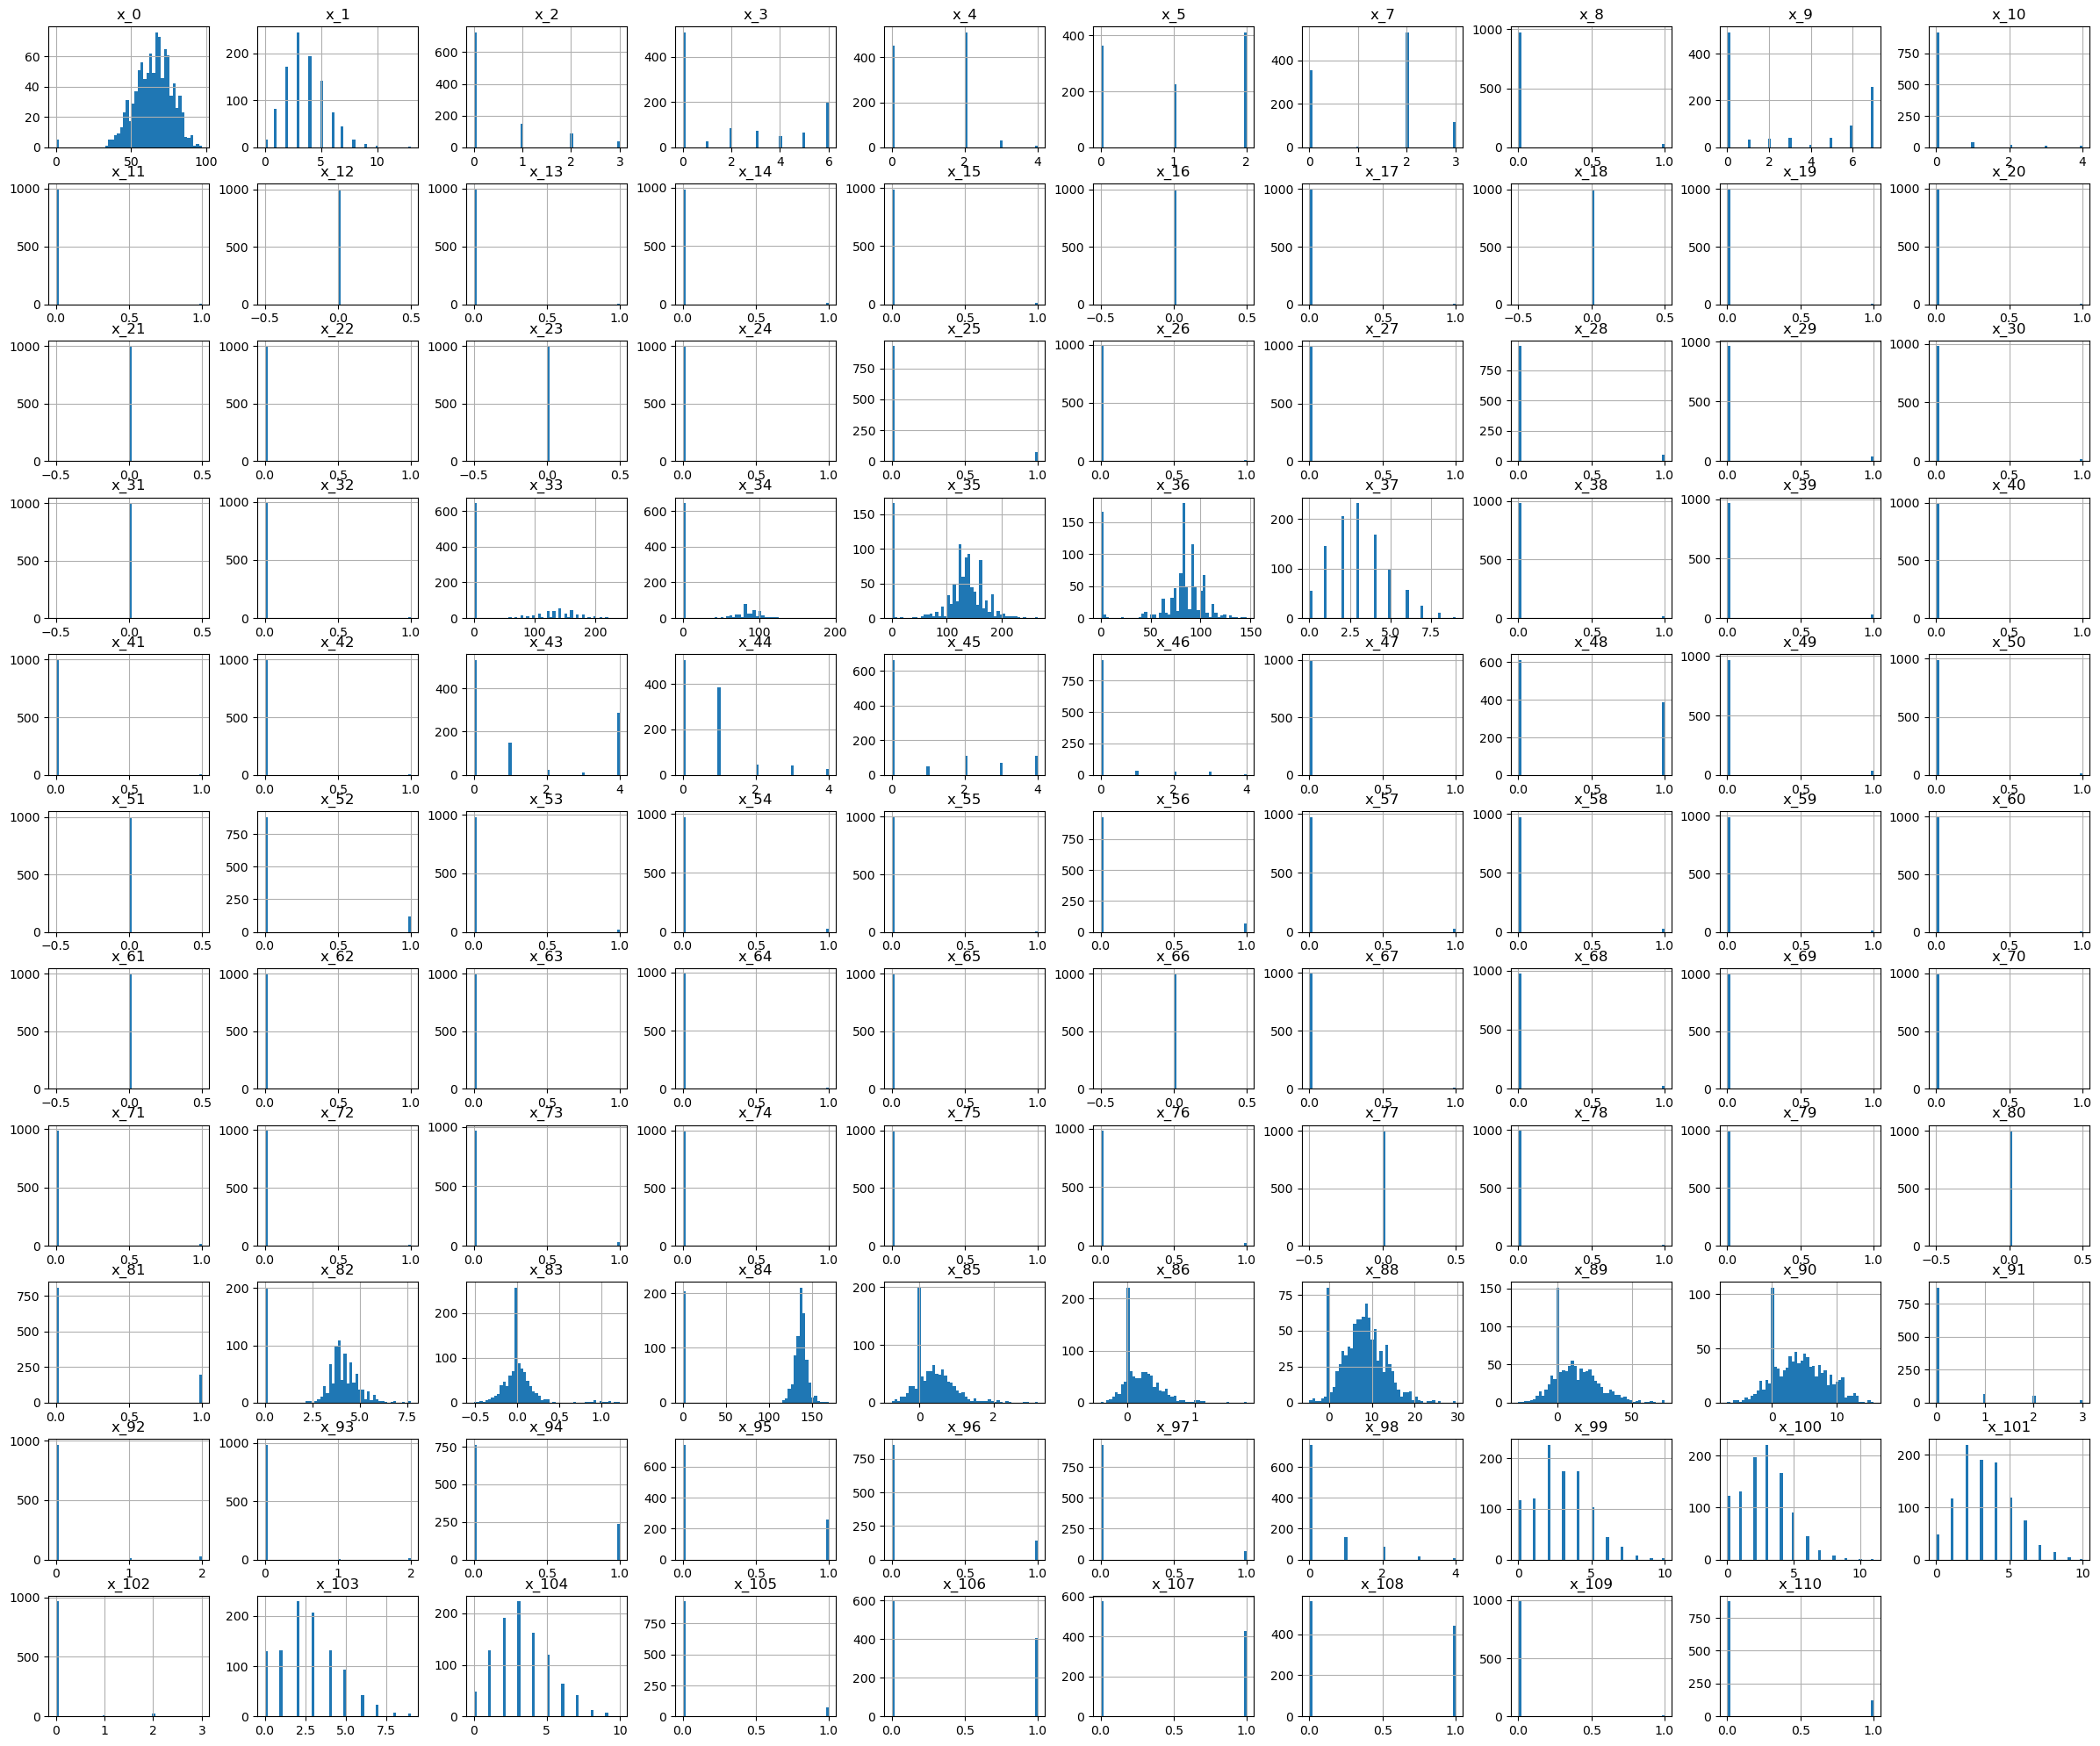

In [109]:
x_train.hist(bins=50, figsize=(30,25))
plt.show()

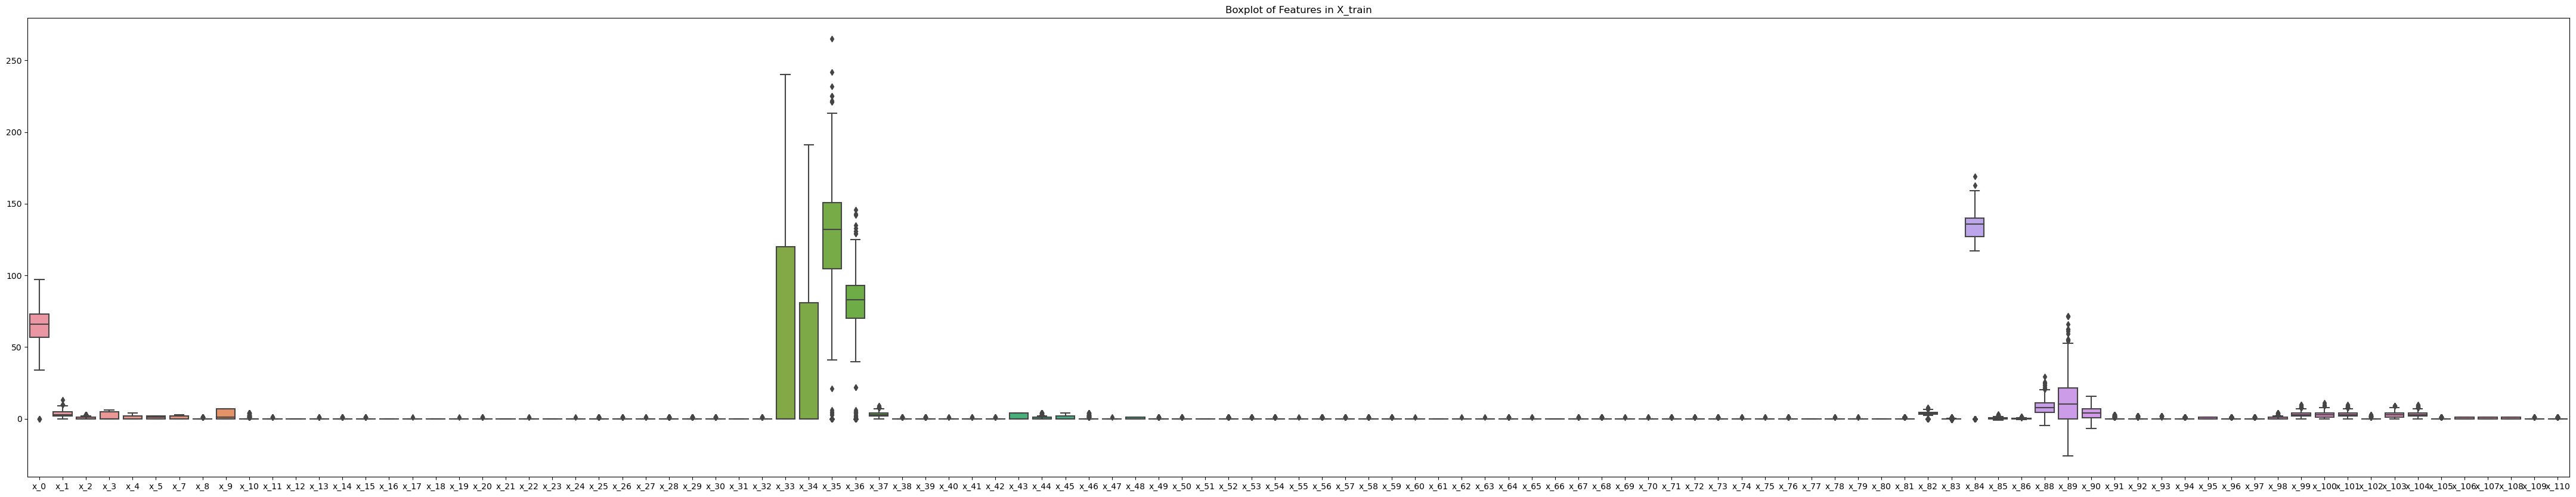

3175


In [110]:
# 画箱形图
plt.figure(figsize=(55, 10))
sns.boxplot(data=x_train)
plt.title('Boxplot of Features in X_train')
plt.show()

# 使用IQR方法来识别和处理离群值
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1

# 定义一个离群值的过滤器，这里不直接修改数据集
outliers_filter = ((x_train < (Q1 - 1.5 * IQR)) | (x_train > (Q3 + 1.5 * IQR)))

# 查看有多少个离群值
print(outliers_filter.sum().sum())

In [111]:
#中位数替换，对极端值不敏感
for col in x_train.columns:
     x_train.loc[outliers_filter[col], col] = x_train[col].median()

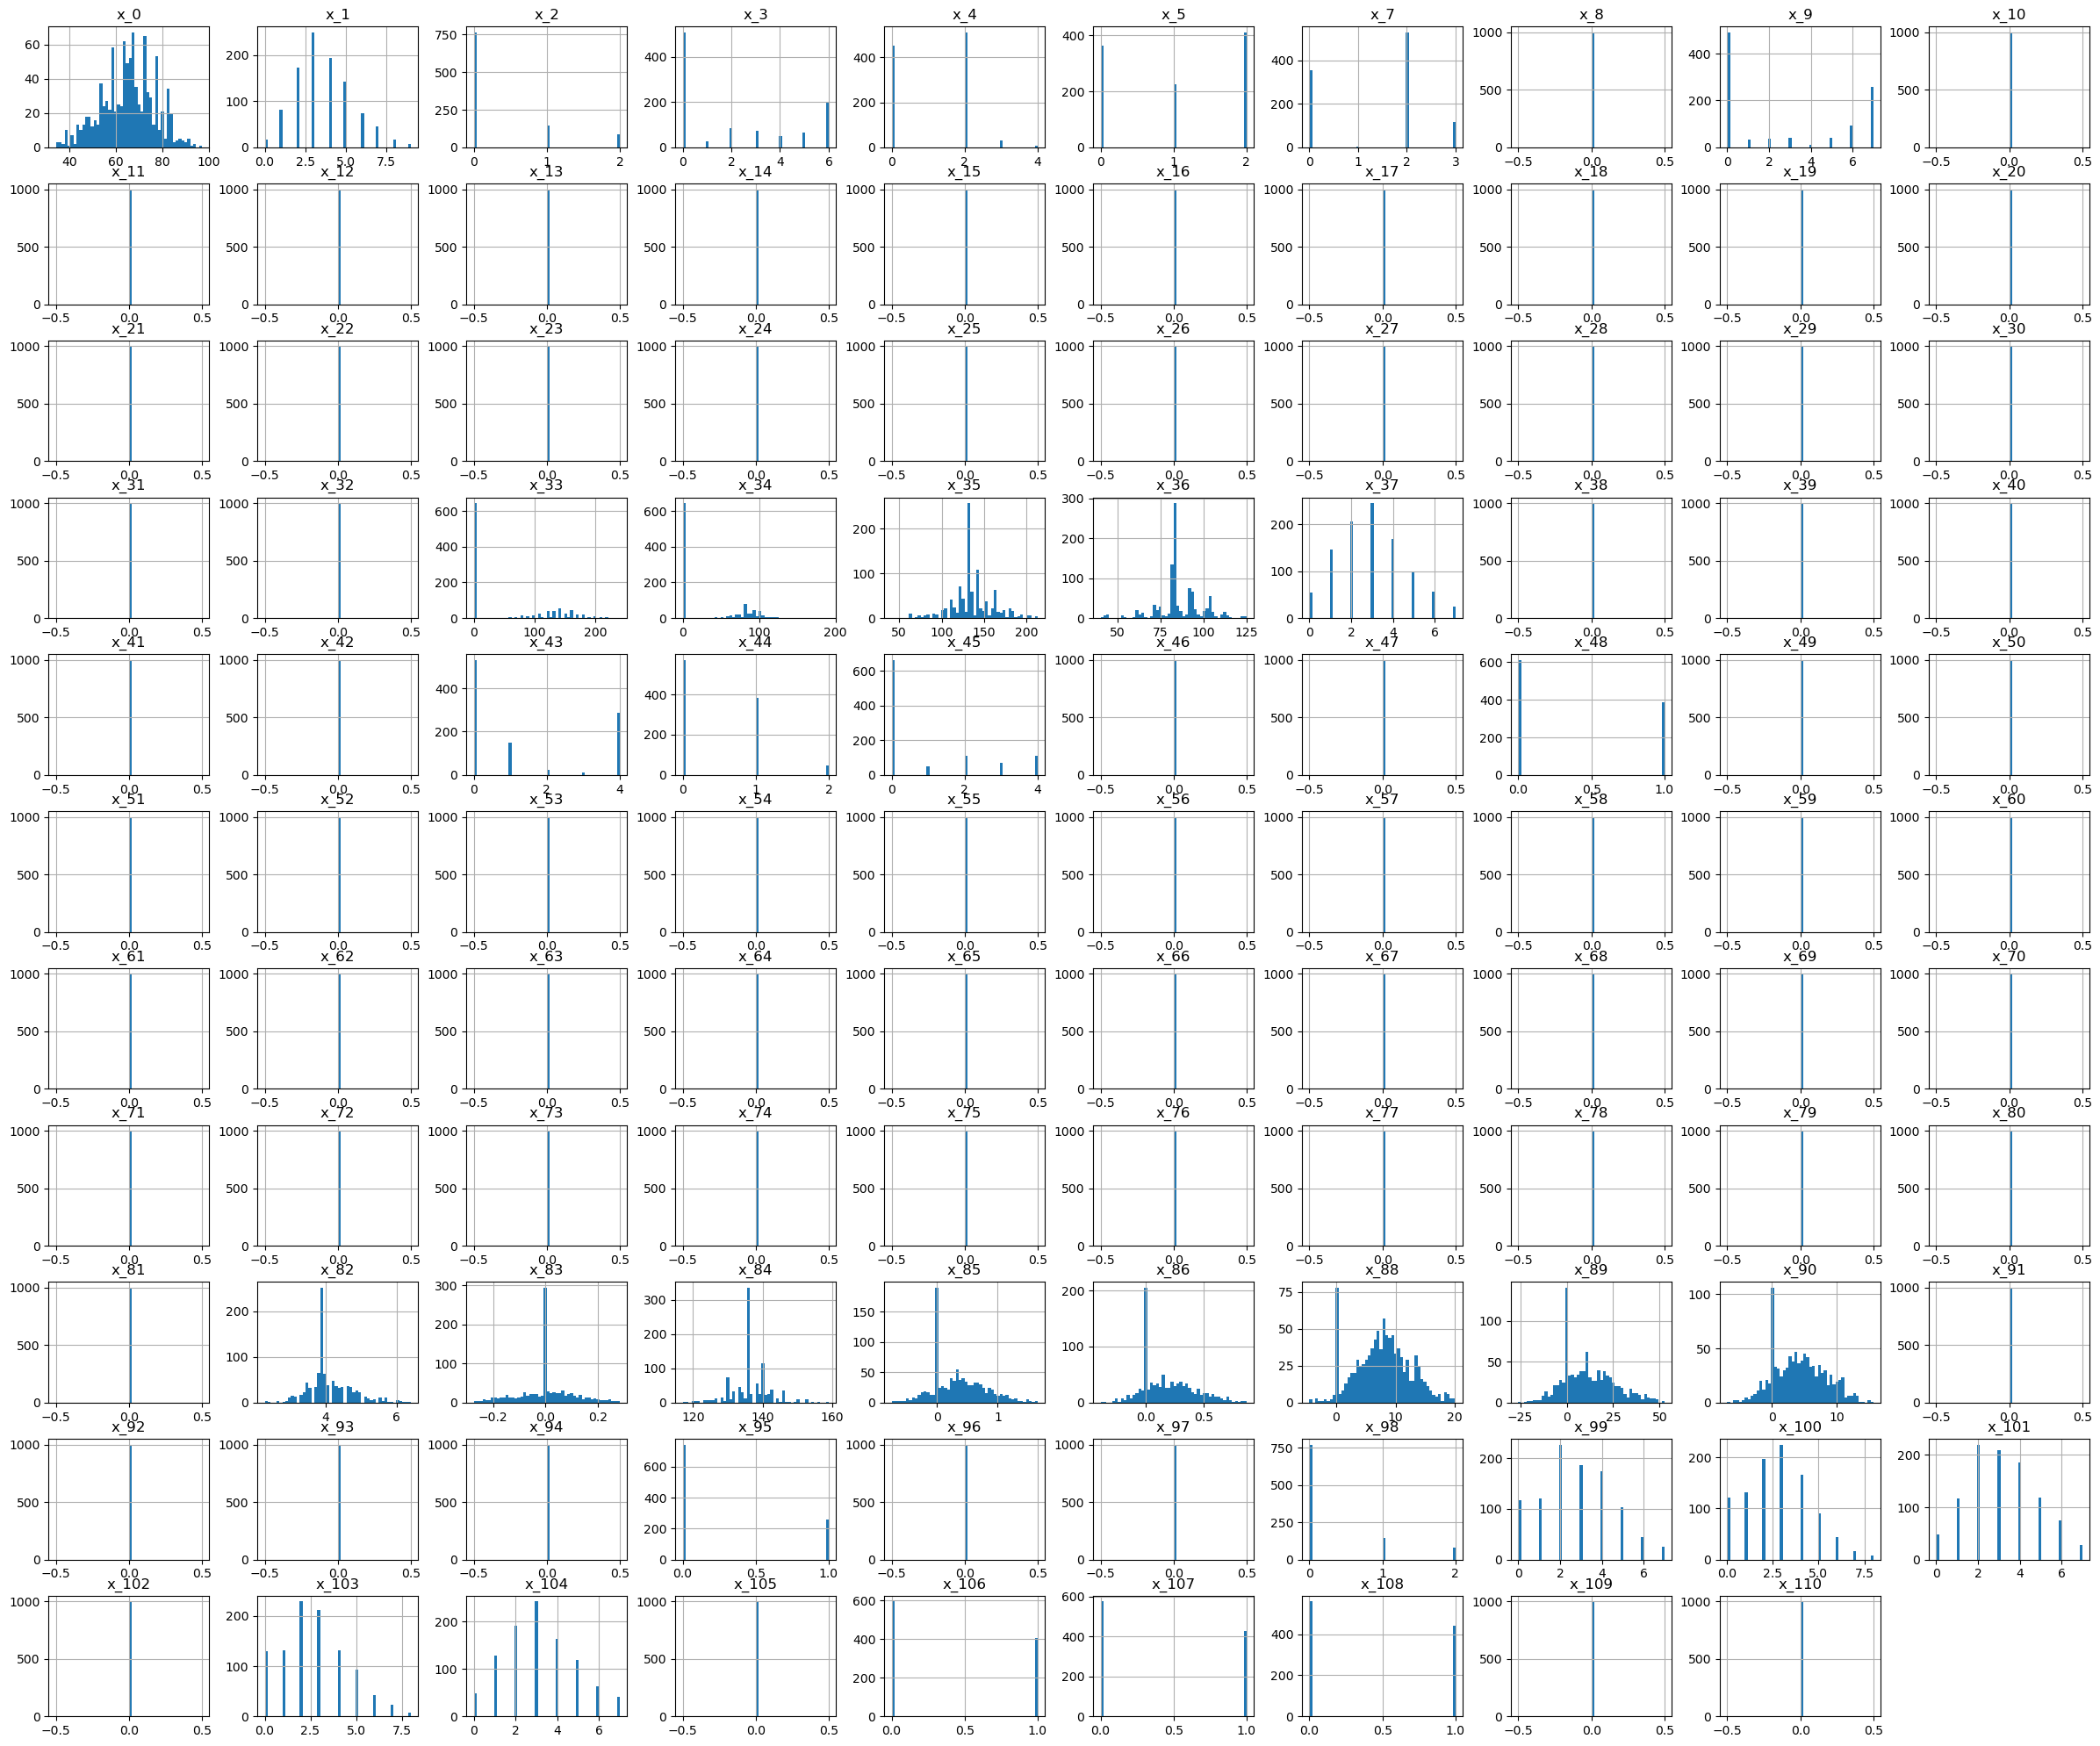

In [112]:
x_train.hist(bins=50, figsize=(30,25))
plt.show()

In [113]:
from sklearn.feature_selection import VarianceThreshold

# 实例化 VarianceThreshold
# 默认情况下，它将移除所有方差为0的特征，即所有值都相同的特征
selector = VarianceThreshold()

# 适用于训练数据
x_train = selector.fit_transform(x_train)

# 适用于测试数据（注意：用训练集的方差阈值来适配测试集）
x_test = selector.transform(x_test)

# 查看剩余的特征数量
print(x_train.shape[1], "features remain in x_train after removing constant features.")
print(x_test.shape[1], "features remain in x_test after removing constant features.")

x_train = pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)

35 features remain in x_train after removing constant features.
35 features remain in x_test after removing constant features.


In [114]:
def loss(y_true, y_pred):
    # 确保 y_true 和 y_pred 都是 DataFrame
    if not isinstance(y_true, pd.DataFrame):
        y_true = pd.DataFrame(y_true)
    if not isinstance(y_pred, pd.DataFrame):
        y_pred = pd.DataFrame(y_pred)
    
    logloss = 0
    # 对每个标签计算log_loss并累加
    for i in range(y_true.shape[1]):  
        logloss += log_loss(y_true.iloc[:, i], y_pred.iloc[:, i], labels=[0,1])
    # 计算平均log_loss
    return logloss / y_true.shape[1]

In [115]:
# 通过make_scorer 把它变成一个loss func
loss_scorer = make_scorer(loss, greater_is_better=False)

In [131]:
# 示例：识别值大多为零的特征
threshold = 0.6  # 定义阈值
unbalanced_features = []
for column in x_train.columns:
    if (x_train[column] == 0).mean() > threshold:
        unbalanced_features.append(column)

print("Unbalanced features:", unbalanced_features)


Unbalanced features: [2, 8, 9, 15, 16, 25, 26]


In [134]:
# 分割数据集
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 初始化模型 - MultiOutputRegressor可以处理多任务的情况
model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))

# 训练模型
model.fit(X_train, Y_train)

# 在验证集上进行预测
Y_pred = model.predict(X_valid)

# 计算均方误差
mse = mean_squared_error(Y_valid, Y_pred)  # 注意这里的 y_true 应该是验证集的目标变量
print("Mean Squared Error:", mse)

# 如果使用自定义的损失函数进行评估
custom_loss_score = loss(Y_valid, Y_pred)
print("Custom Loss Score:", custom_loss_score)
# 计算 R² 分数
r2 = r2_score(Y_valid, Y_pred)
print("R² Score:", r2)

# 计算平均绝对误差
mae = mean_absolute_error(Y_valid, Y_pred)
print("Mean Absolute Error:", mae)

# 计算汉明损失
hamming = hamming_loss(Y_valid, Y_pred > 0.5)  # 使用0.5作为阈值将概率转换为二进制标签
print("Hamming Loss:", hamming)

# 计算 F1 分数，需要二值化预测和实际标签
f1 = f1_score(Y_valid, Y_pred > 0.5, average='samples',zero_division=0)  # 'samples' 计算每个样本的F1分数，然后取平均
print("F1 Score:", f1)
Y_pred_binarized = (Y_pred > 0.5).astype(int)
report = classification_report(Y_valid, Y_pred_binarized, target_names=[f'Label {i}' for i in range(Y_pred_binarized.shape[1])],zero_division=0)
print(report)

Mean Squared Error: 0.196675828461458
Custom Loss Score: 0.6657978004040708
R² Score: -0.06707478475844954
Mean Absolute Error: 0.36894268757353393
Hamming Loss: 0.26136363636363635
F1 Score: 0.10553968253968254
              precision    recall  f1-score   support

     Label 0       0.78      0.11      0.20        62
     Label 1       0.25      0.02      0.04        43
     Label 2       0.33      0.08      0.12        39
     Label 3       0.00      0.00      0.00        38
     Label 4       0.40      0.05      0.09        42
     Label 5       0.46      0.12      0.19        51
     Label 6       0.25      0.02      0.04        51
     Label 7       0.56      0.12      0.20        40
     Label 8       0.40      0.24      0.30        78
     Label 9       0.44      0.08      0.13        51
    Label 10       0.21      0.06      0.09        54

   micro avg       0.40      0.09      0.15       549
   macro avg       0.37      0.08      0.13       549
weighted avg       0.39      0